# Snaphomz Trial Assignment

Name: Yishan Cai\
Location: San Diego, CA

## Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

from rank_bm25 import BM25Okapi
import re

## Data

### Data Cleaning

In [2]:
df = pd.read_csv("../data/listings_sample.csv")

In [3]:
df.head(2)

,id,address,city,state,price,beds,baths,sqft,remarks,agent_id,list_date,media_urls
0,MLS-TX-1000,"960 Cedar Ct, Frisco, TX",Frisco,TX,803788,3,3,3892,"quiet cul-de-sac, two-car garage, near good sc...",AG7396,2025-07-14,"[""https://picsum.photos/seed/0/1200/800""]"
1,MLS-CA-1001,"2658 Elm Dr, Santa Clara, CA",Santa Clara,CA,1908765,3,2,3547,"fresh paint, new roof 2022, large backyard, HO...",AG3612,2024-12-05,"[""https://picsum.photos/seed/1/1200/800""]"


In [4]:
df.shape

(160, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          160 non-null    object
 1   address     160 non-null    object
 2   city        160 non-null    object
 3   state       160 non-null    object
 4   price       160 non-null    int64 
 5   beds        160 non-null    int64 
 6   baths       160 non-null    int64 
 7   sqft        160 non-null    int64 
 8   remarks     160 non-null    object
 9   agent_id    160 non-null    object
 10  list_date   160 non-null    object
 11  media_urls  160 non-null    object
dtypes: int64(4), object(8)
memory usage: 15.1+ KB


In [6]:
# check for missing values
df.isnull().values.any()

False

In [7]:
# adjust value type
df['list_date'] = pd.to_datetime(df['list_date'])

In [8]:
# get needed binary columns from `remarks`
if df['remarks'].dtype == 'object' and isinstance(df['remarks'].iloc[0], str):
    df['remarks'] = df['remarks'].str.split(', ')

all_keywords = set()
for remark_list in df['remarks']:
    all_keywords.update(remark_list)


for keyword in all_keywords:
    col_name = keyword.strip().lower().replace(' ', '_').replace('-', '_')
    df[col_name] = df['remarks'].apply(lambda x: 1 if keyword in x else 0)

In [9]:
# one hot encoding
city_dummies = pd.get_dummies(df['city'], prefix='city', drop_first=True)
state_dummies = pd.get_dummies(df['state'], prefix='state', drop_first=True)
df = pd.concat([df, city_dummies, state_dummies], axis=1)

df['list_year'] = df['list_date'].dt.year
df['list_month'] = df['list_date'].dt.month
df['list_quarter'] = df['list_date'].dt.quarter

In [10]:
df.columns

Index(['id', 'address', 'city', 'state', 'price', 'beds', 'baths', 'sqft',
       'remarks', 'agent_id', 'list_date', 'media_urls', 'primary_suite',
       'quiet_cul_de_sac', 'large_backyard', 'corner_lot', 'new_roof_2022',
       'stainless_appliances', 'vaulted_ceilings', 'walk_to_park',
       'fresh_paint', 'home_office', 'hardwood_floors', 'ev_charger',
       'tile_flooring', 'two_car_garage', 'solar_panels', 'open_concept',
       'near_good_schools', 'updated_kitchen', 'granite_counters',
       'hoa_includes_pool', 'city_Frisco', 'city_Mountain View',
       'city_Palo Alto', 'city_Plano', 'city_San Jose', 'city_Santa Clara',
       'city_Sunnyvale', 'state_TX', 'list_year', 'list_month',
       'list_quarter'],
      dtype='object')

In [11]:
# get the target column
df['price_per_sqft'] = df['price'] / df['sqft']

In [12]:
# see the distribution of non binary numeric variables
df_num = df[['price', 'beds', 'baths', 'sqft', 'price_per_sqft']]
df_num.describe()

,price,beds,baths,sqft,price_per_sqft
count,1.600000e+02,160.000000,160.000000,160.000000,160.000000
mean,1.101729e+06,3.456250,2.156250,2380.987500,452.119885
std,7.879282e+05,0.983172,0.687232,985.057563,230.519406
min,1.751420e+05,2.000000,1.000000,809.000000,183.036332
25%,5.085175e+05,3.000000,2.000000,1479.750000,265.616797
50%,8.630205e+05,3.000000,2.000000,2399.000000,340.672676
75%,1.454584e+06,4.000000,3.000000,3158.250000,608.196822
max,3.528809e+06,5.000000,3.000000,4187.000000,945.615679


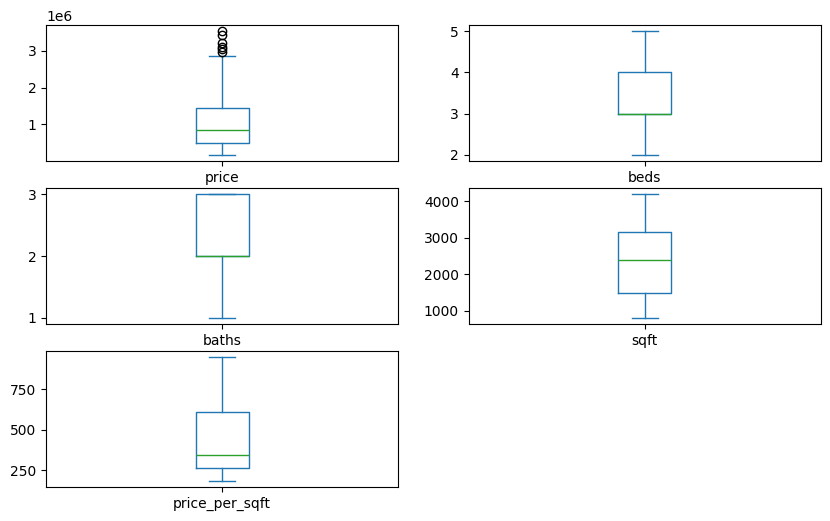

In [13]:
df_num.plot(kind='box', subplots=True, layout=(3,2), figsize=(10,6), sharex=False, sharey=False)
plt.show()

Although there are some outliers in the distribution of `price`, our target variable `price_per_sqrt` does not exhibit any outliers. Since the model predicts `price_per_sqrt` directly, these extreme price values are unlikely to adversely affect the predictions. Therefore, handling outliers is not necessary in this case.

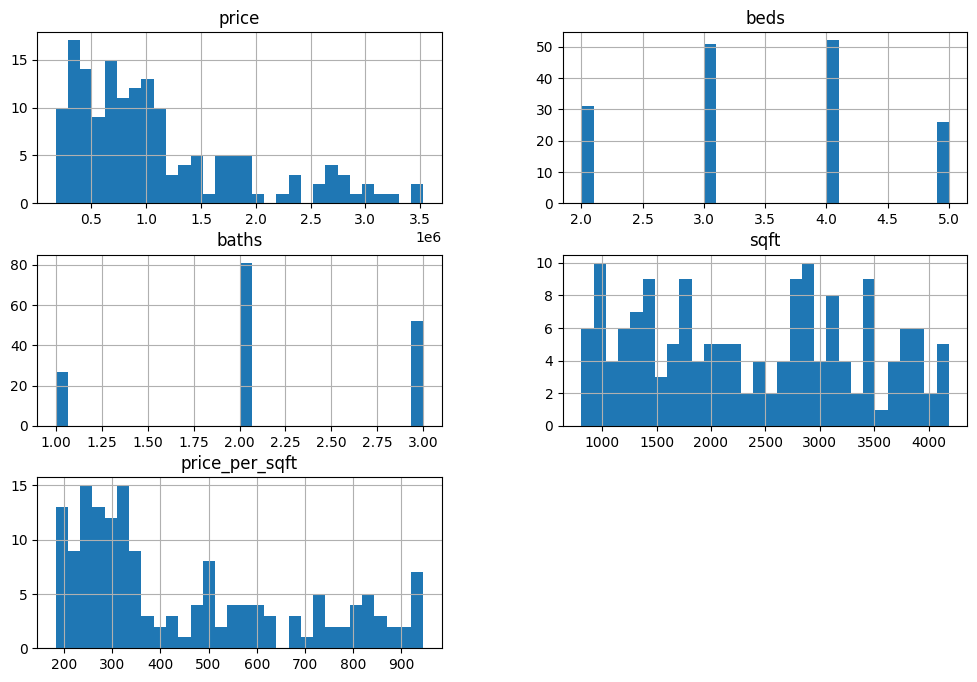

In [14]:
df_num.hist(bins=30, figsize=(12, 8))
plt.show()

We can observe that the distributions of `price` and `price_per_sqrt` are right-skewed, while the distributions of `beds` and `baths` are approximately normal. We might consider applying a log transformation to `price_per_sqrt` during the prediction stage.

### EDA

C:\Users\蔡依珊\AppData\Local\Temp\ipykernel_15076\1671744346.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='city', y='price_per_sqft', data=df, palette=colors)


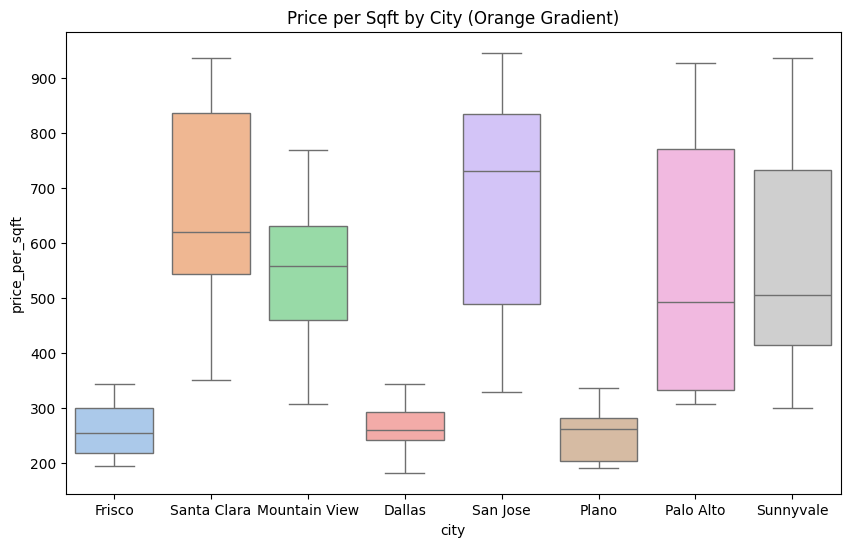

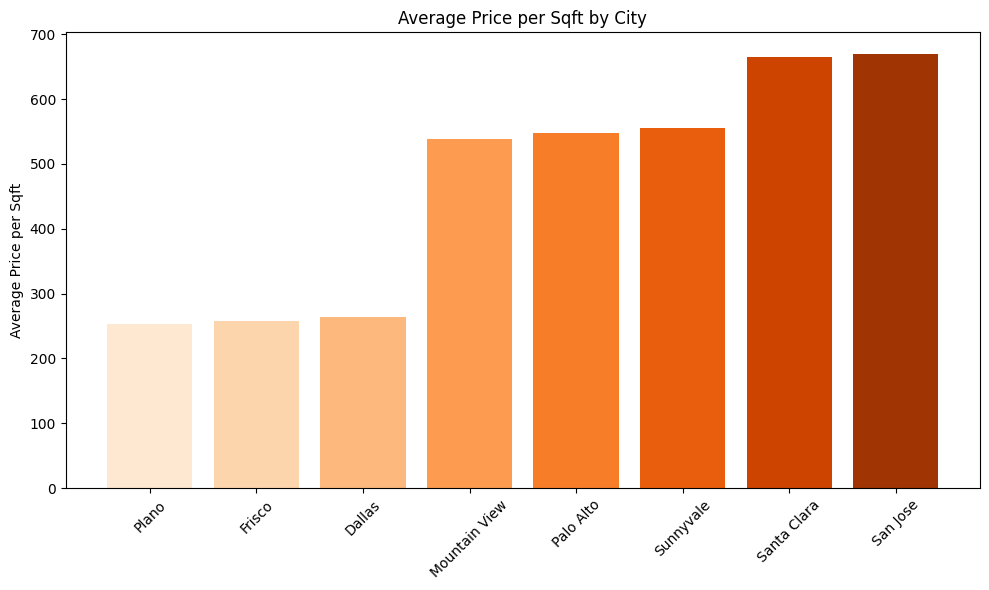

In [15]:
# Boxplot
plt.figure(figsize=(10,6))
city_means = df.groupby('city')['price_per_sqft'].mean().sort_values()
colors = sns.color_palette("pastel", n_colors=len(city_means))
sns.boxplot(x='city', y='price_per_sqft', data=df, palette=colors)
plt.title('Price per Sqft by City (Orange Gradient)')
plt.show()

# Average price per sqft by city
colors = sns.color_palette("Oranges", n_colors=len(city_means))
plt.figure(figsize=(10,6))
plt.bar(city_means.index, city_means.values, color=colors)
plt.ylabel('Average Price per Sqft')
plt.title('Average Price per Sqft by City')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('../results/avg_price_per_sqft_by_city.png')
plt.show()

C:\Users\蔡依珊\AppData\Local\Temp\ipykernel_15076\3779164833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


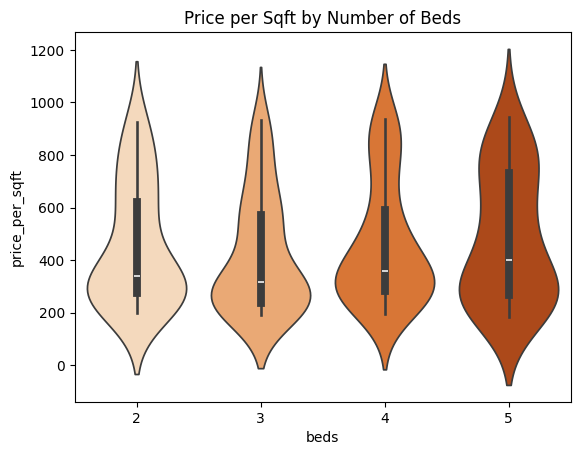

In [16]:
num_beds = df['beds'].nunique()
colors = sns.color_palette("Oranges", n_colors=num_beds)

plt.figure()
sns.violinplot(
    x='beds', 
    y='price_per_sqft', 
    data=df, 
    palette=colors
)
plt.title('Price per Sqft by Number of Beds')
plt.show()

C:\Users\蔡依珊\AppData\Local\Temp\ipykernel_15076\3015888883.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


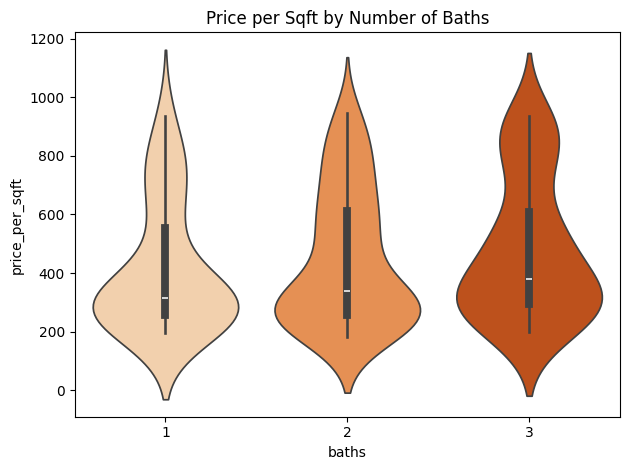

In [17]:
num_baths = df['baths'].nunique()
colors = sns.color_palette("Oranges", n_colors=num_baths)

plt.figure()
sns.violinplot(
    x='baths', 
    y='price_per_sqft', 
    data=df, 
    palette=colors
)
plt.title('Price per Sqft by Number of Baths')

plt.tight_layout()
plt.savefig('../results/price_per_sqft_by_baths.png')
plt.show()

C:\Users\蔡依珊\AppData\Local\Temp\ipykernel_15076\425558918.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


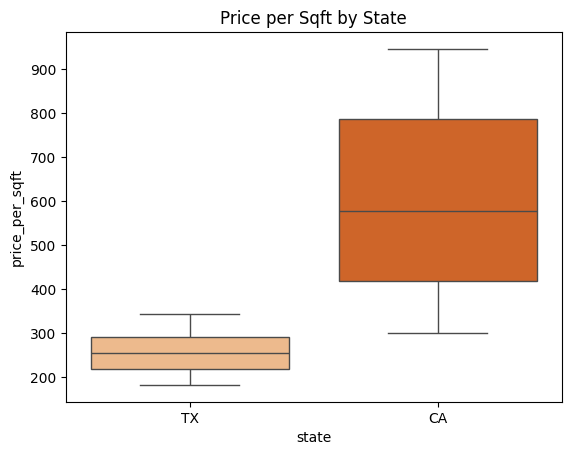

In [18]:
plt.figure()
sns.boxplot(
    x='state', 
    y='price_per_sqft', 
    data=df, 
    palette="Oranges"
)
plt.title('Price per Sqft by State')
plt.show()

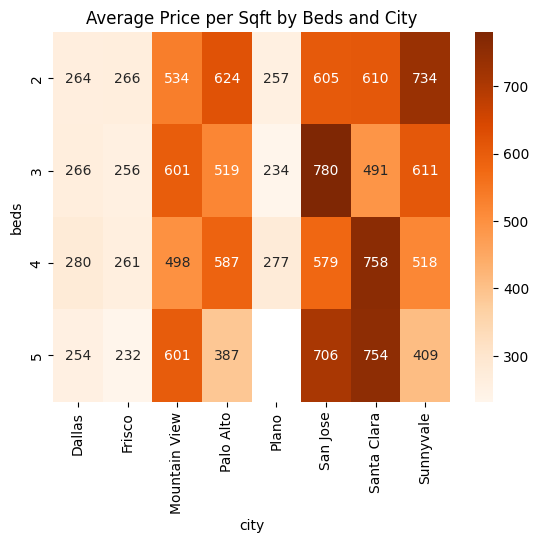

In [19]:
pivot = df.pivot_table(index='beds', columns='city', values='price_per_sqft', aggfunc='mean')
sns.heatmap(pivot, cmap='Oranges', annot=True, fmt=".0f")
plt.title('Average Price per Sqft by Beds and City')
plt.show()

Concise Insights:
- Geographic location drives the largest price variations, with California cities (Palo Alto, Santa Clara) commanding 2-3x higher prices per square foot than Texas cities (Dallas, Frisco).
 - Properties with more bathrooms command progressively higher prices per square foot, with 3-bathroom homes showing the highest median around $400-500/sqft.
 - The number of bedrooms has minimal impact on price per square foot, with all categories (2-5 beds) showing similar median values around $300-400/sqft.

## Prediction

### Baseline Model - Regression

In [20]:
df_model = df.copy()
drop_cols = ['id', 'address', 'city', 'state', 'price', 'sqft', 'remarks', 'agent_id', 'media_urls', 'list_date']
df_model.drop(columns=drop_cols, inplace=True)

In [21]:
df_model.columns

Index(['beds', 'baths', 'primary_suite', 'quiet_cul_de_sac', 'large_backyard',
       'corner_lot', 'new_roof_2022', 'stainless_appliances',
       'vaulted_ceilings', 'walk_to_park', 'fresh_paint', 'home_office',
       'hardwood_floors', 'ev_charger', 'tile_flooring', 'two_car_garage',
       'solar_panels', 'open_concept', 'near_good_schools', 'updated_kitchen',
       'granite_counters', 'hoa_includes_pool', 'city_Frisco',
       'city_Mountain View', 'city_Palo Alto', 'city_Plano', 'city_San Jose',
       'city_Santa Clara', 'city_Sunnyvale', 'state_TX', 'list_year',
       'list_month', 'list_quarter', 'price_per_sqft'],
      dtype='object')

Train Test split

In [22]:
X = df_model.drop('price_per_sqft', axis=1)
y = df_model['price_per_sqft']

# Log transform target
# We mentioned the distribution of `price_per_sqft` is right skewed, 
# and in order to better do the prediction job, we need to log transform it firstly.
y_log = np.log(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Lasso

In [23]:
lasso = LassoCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5)
lasso.fit(X_train_scaled, y_train)

y_pred_log = lasso.predict(X_test_scaled)
y_pred = np.exp(y_pred_log)  # transform back to original scale
y_test_original = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"RMSE: ${rmse:.2f}/sqft")
print(f"MAE: ${mae:.2f}/sqft")
print(f"R2: {r2:.3f}")

RMSE: $171.14/sqft
MAE: $122.72/sqft
R2: 0.465


Random Forest

In [24]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

model.fit(X_train_scaled, y_train)

y_pred_log = model.predict(X_test_scaled)
y_pred = np.exp(y_pred_log)  # transform back to original scale
y_test_original = np.exp(y_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"RMSE: ${rmse:.2f}/sqft")
print(f"MAE: ${mae:.2f}/sqft")
print(f"R2: {r2:.3f}")

RMSE: $167.97/sqft
MAE: $122.43/sqft
R2: 0.484


Hyperparameter Tuning

In [25]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_split': [5, 10, 15],
#     'min_samples_leaf': [2, 5, 10],
#     'max_features': ['sqrt', 'log2', None]
# }

# rf = RandomForestRegressor(random_state=42)

# # GridSearchCV
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=5,
#     scoring='r2',  # 'neg_mean_squared_error'
#     n_jobs=1,
#     verbose=2
# )

# print("Start GridSearch")
# grid_search.fit(X_train_scaled, y_train)

# print("Best params:")
# print(grid_search.best_params_)
# print(f"\nBest CV R2: {grid_search.best_score_:.3f}")

# best_model = grid_search.best_estimator_
# y_pred_log = best_model.predict(X_test_scaled)
# y_pred = np.exp(y_pred_log)
# y_test_original = np.exp(y_test)

# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
# mae = mean_absolute_error(y_test_original, y_pred)
# r2 = r2_score(y_test_original, y_pred)

# print("Test Dataset:")
# print(f"RMSE: ${rmse:.2f}/sqft")
# print(f"MAE: ${mae:.2f}/sqft")
# print(f"R2: {r2:.3f}")

In [26]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=10,
    random_state=42
)

model.fit(X_train_scaled, y_train)

y_pred_log = model.predict(X_test_scaled)
y_pred = np.exp(y_pred_log)  # transform back to original scale
y_test_original = np.exp(y_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"RMSE: ${rmse:.2f}/sqft")
print(f"MAE: ${mae:.2f}/sqft")
print(f"R2: {r2:.3f}")

RMSE: $164.34/sqft
MAE: $119.76/sqft
R2: 0.507


**Predictive Model Takeaways:**
- Tuned Random Forest achieved R2=0.506 (RMSE=$164/sqft), capturing non-linear relationships between location, property features, and price that linear models missed.
- Shallow trees (max_depth=3) with larger leaf sizes (min_samples_leaf=10) proved optimal for preventing overfitting on the 160-property dataset.
- The model explains half of price variance, with remaining variation likely driven by unmeasured factors like precise location, property condition, and seasonal market dynamics.

## LLM Feature

In [27]:
def prepare_corpus(df):
    corpus = []
    for remarks in df['remarks']:
        if isinstance(remarks, list):
            text = ' '.join(remarks)
        else:
            text = str(remarks)
        tokens = text.lower().replace(',', ' ').split()
        corpus.append(tokens)
    return corpus

corpus = prepare_corpus(df)
bm25 = BM25Okapi(corpus)

keyword_map = {
    'hardwood': 'hardwood_floors',
    'hardwood floors': 'hardwood_floors',
    'pool': 'hoa_includes_pool',
    'garage': 'two_car_garage',
    'two-car garage': 'two_car_garage',
    'two car garage': 'two_car_garage',
    'kitchen': 'updated_kitchen',
    'updated kitchen': 'updated_kitchen',
    'school': 'near_good_schools',
    'schools': 'near_good_schools',
    'good schools': 'near_good_schools',
    'backyard': 'large_backyard',
    'large backyard': 'large_backyard',
    'solar': 'solar_panels',
    'solar panels': 'solar_panels',
    'ev charger': 'ev_charger',
    'cul-de-sac': 'quiet_cul_de_sac',
    'cul de sac': 'quiet_cul_de_sac',
    'quiet': 'quiet_cul_de_sac',
    'vaulted ceilings': 'vaulted_ceilings',
    'granite': 'granite_counters',
    'granite counters': 'granite_counters',
    'new roof': 'new_roof_2022',
    'roof': 'new_roof_2022',
    'stainless': 'stainless_appliances',
    'stainless appliances': 'stainless_appliances',
    'tile': 'tile_flooring',
    'tile flooring': 'tile_flooring',
    'open concept': 'open_concept',
    'home office': 'home_office',
    'primary suite': 'primary_suite',
    'corner lot': 'corner_lot',
    'walk to park': 'walk_to_park',
    'fresh paint': 'fresh_paint',
}

def extract_address_from_question(question):
    pattern = r'(\d+\s+[A-Za-z\s]+?(?:St|Street|Ct|Court|Ave|Avenue|Dr|Drive|Rd|Road|Ln|Lane|Way|Blvd|Boulevard))'
    
    match = re.search(pattern, question, re.IGNORECASE)
    if match:
        potential_address = match.group(1).strip()
        for addr in df['address'].values:
            if potential_address.lower() in addr.lower():
                return addr
        return potential_address
    return None

def rag_qa(question):
    extracted_address = extract_address_from_question(question)
    
    if extracted_address:
        house = df[df['address'].str.contains(extracted_address, case=False, na=False)]
        if not house.empty:
            house = house.iloc[0]
            address = house['address']
        else:
            return f"Address '{extracted_address}' not found in database.", ""
    else:
        return f"Address '{extracted_address}' not found in database.", ""
    
    if isinstance(house['remarks'], list):
        remarks_text = ', '.join(house['remarks'])
    else:
        remarks_text = str(house['remarks'])
    
    question_lower = question.lower()
    sorted_keywords = sorted(keyword_map.items(), key=lambda x: len(x[0]), reverse=True)
    
    for keyword, column in sorted_keywords:
        if keyword in question_lower:
            if column in house.index and house[column] == 1:
                return f"Yes, {address} has {keyword}.", f"Supporting evidence: {remarks_text}"
            elif column in house.index and house[column] == 0:
                return f"No, {address} does not have {keyword}.", f"Property features: {remarks_text}"
    
    return f"I couldn't identify a specific feature in your question about {address}.", f"Available features: {remarks_text}"

In [28]:
def main():
    print("="*80)
    print("RAG Q&A System - Automatic Address Extraction")
    print("="*80)
    
    test_questions = [
        "Does 960 Cedar Ct, Frisco, TX have hardwood floors?",
        "Does 960 Cedar Ct have a two-car garage?",
        "960 Cedar Ct - is there a pool?",
        "Which property has solar panels?",
        "Are there any homes with updated kitchen?",
        "I'm interested in 960 Cedar Ct. Does it have good schools nearby?",
    ]
    
    for question in test_questions:
        print(f"\nQ: {question}")
        answer, evidence = rag_qa(question)
        print(f"A: {answer}")
        print(f"   {evidence[:100]}...")
        print("-"*80)
    
    while True:
        user_question = input("\nEnter your question (or 'exit' to quit): ")
        if user_question.lower() == 'exit':
            break
        answer, evidence = rag_qa(user_question)
        print(f"A: {answer}")
        print(f"Evidence: {evidence}\n")

if __name__ == "__main__":
    main()

RAG Q&A System - Automatic Address Extraction

Q: Does 960 Cedar Ct, Frisco, TX have hardwood floors?
A: No, 960 Cedar Ct, Frisco, TX does not have hardwood floors.
   Property features: quiet cul-de-sac, two-car garage, near good schools, vaulted ceilings, updated ki...
--------------------------------------------------------------------------------

Q: Does 960 Cedar Ct have a two-car garage?
A: Yes, 960 Cedar Ct, Frisco, TX has two-car garage.
   Supporting evidence: quiet cul-de-sac, two-car garage, near good schools, vaulted ceilings, updated ...
--------------------------------------------------------------------------------

Q: 960 Cedar Ct - is there a pool?
A: Yes, 960 Cedar Ct, Frisco, TX has pool.
   Supporting evidence: quiet cul-de-sac, two-car garage, near good schools, vaulted ceilings, updated ...
--------------------------------------------------------------------------------

Q: Which property has solar panels?
A: Address 'None' not found in database.
   ...
---------